In [57]:
# Required Libraries
import pandas as pd
import json
import pymongo
import certifi
from matplotlib import pyplot, ticker
import seaborn

Connection Methodology Derived from Professor Theodore Spence: 
https://github.com/tspence/data-analysis-class-resources/blob/main/jupyter/Basics%20of%20Loading%20Data.ipynb

In [2]:
# Access Credentials File
with open('C:\\Users\\JaredM\\Downloads\\secrets.json') as f:
    data = json.load(f)

    connection_string = data['mongodb']

# Verify connection string was fetched
# print(f"My secret key is {len(connection_string)} characters in length.")

In [47]:
# Connect to Database
client = pymongo.MongoClient(connection_string, tlsCAFile=certifi.where())

# Fetch Database
movie_database = client['Movies']

# Fetch Collections In Database
collections = movie_database.list_collection_names()

# Verify collections found
print(f"Using MongoDB version {client.server_info()['version']}.")
print(f"This database has the collections {collections}")

Using MongoDB version 6.0.6.
This database has the collections ['metacritic', 'imdb', 'imdb-pipeline']


In [48]:
# Formats large numbers into shorthand
# Derived from Professor Theodore Spence's Currency Converter: https://github.com/tspence/data-analysis-class-resources/blob/main/jupyter/Basics%20of%20Plotting.ipynb
def format_largeNum(amount, _):
    if amount > 1_000_000_000:
        return f"{round(amount / 1_000_000_000)}B"
    elif amount > 1_000_000:
        return f"{round(amount / 1_000_000)}M"
    elif amount > 1_000:
        return f"{round(amount / 1_000)}K"
    else:
        return f"{round(amount)}"

<function matplotlib.pyplot.show(close=None, block=None)>

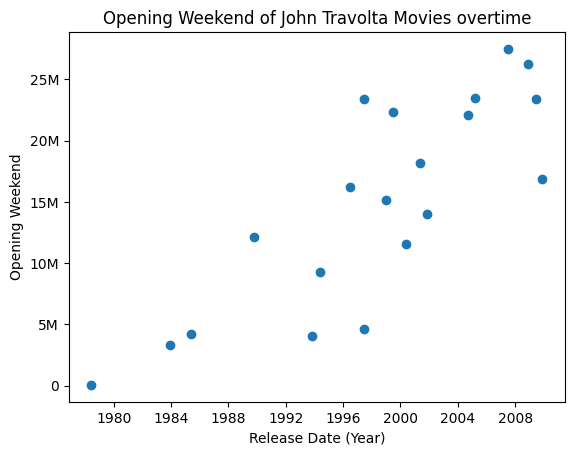

In [61]:
# Load imdb collection view, queried for John Travolta Films
cursor = movie_database["imdb-pipeline"].find({ "cast": { "$in": ["John Travolta"]} })

# Convert this information into a Pandas dataframe
imdb = pd.DataFrame(cursor)

# Check data
# imdb.head()

# Plot Opening Weekend of John Travolta Movies overtime

pyplot.title('Opening Weekend of John Travolta Movies overtime')
pyplot.xlabel('Release Date (Year)')
pyplot.ylabel('Opening Weekend')
pyplot.scatter(imdb.release_date, imdb.opening_weekend)
pyplot.gca().yaxis.set_major_formatter(format_largeNum)
pyplot.show

Seems like his appeal has only grown!

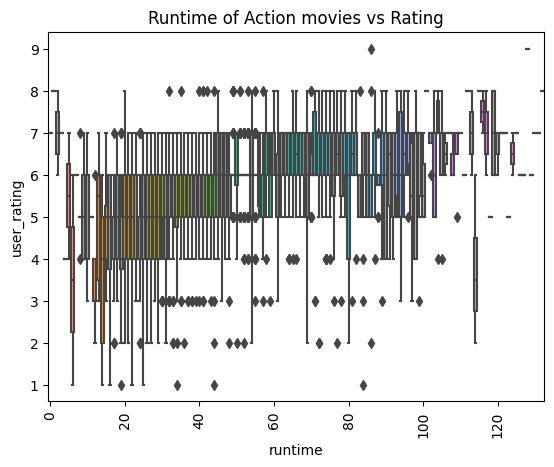

In [62]:
# Load imdb collection view, queried for Action Films
cursor = movie_database["imdb-pipeline"].find({ "genre": { "$in": ["Action"]} })

# Convert this information into a Pandas dataframe
imdb = pd.DataFrame(cursor)

# Plot Gross Sales of Action Movies Overtime

chart = seaborn.boxplot(data = imdb, x = "runtime", y="user_rating")
chart.set_title("Runtime of Action movies vs Rating")
chart.xaxis.set_major_locator(ticker.MultipleLocator(20))
chart.xaxis.set_major_formatter(ticker.ScalarFormatter())
for item in chart.get_xticklabels():
    item.set_rotation(90)

Movies less than an hour seem to average lower than those closer to an hour or more. Looks like regardless of length, everything tops out around a score of 7-8.

<function matplotlib.pyplot.show(close=None, block=None)>

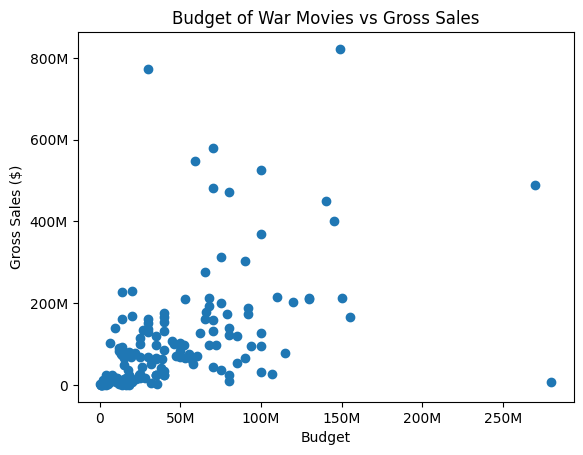

In [67]:
# Load imdb collection view, queried for War Films. Shifted range to only those less then $300M Budget due to outliers
cursor = movie_database["imdb-pipeline"].find({ "genre": { "$in": ["War"]}, "budget": {"$lt": 300000000}})

# Convert this information into a Pandas dataframe
imdb = pd.DataFrame(cursor)

# Check data
# imdb.head()

# Plot Budget of War Movies vs Gross Sales

pyplot.title("Budget of War Movies vs Gross Sales")
pyplot.xlabel('Budget')
pyplot.ylabel('Gross Sales ($)')
pyplot.scatter(imdb.budget, imdb.gross_sales)
pyplot.gca().xaxis.set_major_formatter(format_largeNum)
pyplot.gca().yaxis.set_major_formatter(format_largeNum)
pyplot.show

Expected general positive trend.

Aggregation Pipeline
[
    {
        '$project': {
            'runtime': {
                '$convert': {
                    'input': '$runtime', 
                    'to': 'int', 
                    'onError': None
                }
            }, 
            'user_rating': {
                '$convert': {
                    'input': '$user_rating', 
                    'to': 'int', 
                    'onError': None
                }
            }, 
            'votes': {
                '$convert': {
                    'input': '$votes', 
                    'to': 'int', 
                    'onError': None
                }
            }, 
            'budget': {
                '$convert': {
                    'input': '$budget', 
                    'to': 'int', 
                    'onError': None
                }
            }, 
            'opening_weekend': {
                '$convert': {
                    'input': '$opening_weekend', 
                    'to': 'int', 
                    'onError': None
                }
            }, 
            'gross_sales': {
                '$convert': {
                    'input': '$gross_sales', 
                    'to': 'int', 
                    'onError': None
                }
            }, 
            'release_date': {
                '$convert': {
                    'input': '$release_date', 
                    'to': 'date', 
                    'onError': None
                }
            }, 
            'genre': {
                '$map': {
                    'input': {
                        '$split': [
                            '$genres', ','
                        ]
                    }, 
                    'as': 'split', 
                    'in': {
                        '$trim': {
                            'input': '$$split'
                        }
                    }
                }
            }, 
            'cast': {
                '$map': {
                    'input': {
                        '$split': [
                            '$cast', ','
                        ]
                    }, 
                    'as': 'split', 
                    'in': {
                        '$trim': {
                            'input': '$$split'
                        }
                    }
                }
            }, 
            'director': {
                '$map': {
                    'input': {
                        '$split': [
                            '$director', ','
                        ]
                    }, 
                    'as': 'split', 
                    'in': {
                        '$trim': {
                            'input': '$$split'
                        }
                    }
                }
            }, 
            'producer': {
                '$map': {
                    'input': {
                        '$split': [
                            '$producer', ','
                        ]
                    }, 
                    'as': 'split', 
                    'in': {
                        '$trim': {
                            'input': '$$split'
                        }
                    }
                }
            }, 
            'company': {
                '$map': {
                    'input': {
                        '$split': [
                            {
                                '$toString': '$company'
                            }, ','
                        ]
                    }, 
                    'as': 'split', 
                    'in': {
                        '$trim': {
                            'input': '$$split'
                        }
                    }
                }
            }, 
            'mpaa_rating': {
                '$map': {
                    'input': {
                        '$split': [
                            '$mpaa_rating', '::'
                        ]
                    }, 
                    'as': 'split', 
                    'in': {
                        '$trim': {
                            'input': '$$split'
                        }
                    }
                }
            }
        }
    }, {
        '$addFields': {
            'age_rating': {
                '$arrayElemAt': [
                    '$mpaa_rating', 0
                ]
            }
        }
    }, {
        '$match': {
            'budget': {
                '$lt': 40000000000
            }, 
            'runtime': {
                '$lt': 400
            }
        }
    }
]